<a href="https://colab.research.google.com/github/dmuman/ML-labs/blob/main/lab3/lab3_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [872]:
import numpy as np
import pandas as pd

# 1

In [873]:
url = 'https://raw.githubusercontent.com/OlhaOsypova/Machine-Learning-and-Data-Analytics/refs/heads/main/Topic_4_regression/Task/clients_LTV.csv'

df = pd.read_csv(url)

df.head()

,Unnamed: 0,Customer_ID,Age,Location,Income_Level,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,App_Usage_Frequency,Preferred_Payment_Method,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,LTV
0,0,cust_0000,54,Urban,Low,192,16736.38402319893$,60216.83450988285$,6525.814860765247$,3.213386e+06,140,209,2114.0,25,2224.012140,Monthly,Debit Card,3,61.568590,1,3.279546e+05
1,1,cust_0001,67,Suburban,High,979,14536.734682848608$,48350.10027249861$,2186.742245256916$,1.423146e+07,229,240,2960.0,20,4026.823518,Monthly,UPI,17,60.392889,8,1.437053e+06
2,2,cust_0002,44,Urban,High,329,7061.372800216672$,32521.157187328816$,2743.4068078554915$,NaN,73,21,3170.0,0,1441.011395,NaN,Debit Card,11,45.305579,4,2.419387e+05
3,3,cust_0003,30,Rural,High,71,16426.876453277957$,17827.896720459485$,4360.78499399125$,NaN,299,285,NaN,35,4365.855580,NaN,Wallet Balance,6,22.030191,1,1.284599e+05
4,4,cust_0004,58,Urban,Middle,878,10800.09265965521$,17497.634533762135$,4532.872520080136$,9.482481e+06,236,329,1992.0,18,4161.523827,Daily,UPI,18,20.634723,5,9.569514e+05


In [874]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   7000 non-null   int64  
 1   Customer_ID                  7000 non-null   object 
 2   Age                          7000 non-null   int64  
 3   Location                     6650 non-null   object 
 4   Income_Level                 6510 non-null   object 
 5   Total_Transactions           7000 non-null   int64  
 6   Avg_Transaction_Value        7000 non-null   object 
 7   Max_Transaction_Value        7000 non-null   object 
 8   Min_Transaction_Value        7000 non-null   object 
 9   Total_Spent                  5950 non-null   float64
 10  Active_Days                  7000 non-null   int64  
 11  Last_Transaction_Days_Ago    7000 non-null   int64  
 12  Loyalty_Points_Earned        6370 non-null   float64
 13  Referral_Count    

# 2

методи для очищення

In [875]:
def convertCatToNum(dataframe, columns_to_change: list, sign_to_change: str, new_sign: str):
  converted_df = dataframe.copy()
  regex = r'[^\d\.]'

  for column in columns_to_change:
    converted_df[column] = converted_df[column].str.replace(sign_to_change, new_sign, regex=False)
    converted_df[column] = converted_df[column].astype(float)

  return converted_df

In [876]:
def fillNaNNumerical(dataframe, column_to_group_by: str, trans_method: str):
  filled_df = dataframe.copy()
  numerical_columns = filled_df.select_dtypes([float, int]).columns

  for column in numerical_columns:
    filled_df.loc[:, column] = filled_df[column].fillna(filled_df.groupby(column_to_group_by)[column].transform(trans_method))

  return filled_df


def fillNaNCategorical(dataframe, columns_to_fill: list):
  filled_df = dataframe.copy()
  for column in columns_to_fill:
    filled_df.loc[:, column] = filled_df[column].fillna(filled_df[column].mode()[0])

  return filled_df

In [877]:
def clean_dataframe(dataframe, columns_to_delete: list):
  df_cleaned = dataframe.copy()
  df_cleaned.drop(columns_to_delete, axis=1, inplace=True)

  numerical_columns = df_cleaned.select_dtypes(include=[float, int]).columns

  for column in numerical_columns:
    lower_bound = df_cleaned[column].quantile(0.05)
    upper_bound = df_cleaned[column].quantile(0.95)

    df_without_bounds = df_cleaned[((df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)) | (df_cleaned[column].isna())]

  df_cleaned = df_without_bounds
  df_cleaned = df_cleaned.dropna(thresh = len(df_cleaned) * 0.5, axis=1)

  return df_cleaned

In [878]:
def getX_y(dataframe, y_column: str):
  X = dataframe.drop([y_column], axis=1)
  y = dataframe[y_column]

  X.index = range(dataframe.shape[0])
  y.index = range(dataframe.shape[0])

  return X, y

In [879]:
columns_to_change = ['Avg_Transaction_Value', 'Max_Transaction_Value', 'Min_Transaction_Value']
df = convertCatToNum(df, columns_to_change, '$', '')

df = fillNaNNumerical(df, 'Age', 'mean')

columns_to_fill = ['Income_Level', 'App_Usage_Frequency']
df = fillNaNCategorical(df, columns_to_fill)

columns_to_delete = ['Unnamed: 0', 'Customer_ID', 'Location']

df = clean_dataframe(df, columns_to_delete)

In [880]:
X, y = getX_y(df, 'LTV')

стандартизація

In [881]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=[float, int]).columns

def standardizeDF(dataframe, numerical_columns, categorical_columns):
  stand_enc_df = dataframe.copy()

  scaler_numerical = StandardScaler()

  standardized_columns = scaler_numerical.fit_transform(stand_enc_df[numerical_columns])

  standardized_stand_enc_df = pd.DataFrame(standardized_columns, columns=numerical_columns, index=stand_enc_df.index)

  stand_enc_df = stand_enc_df.drop(columns=numerical_columns)

  stand_enc_df = pd.concat([stand_enc_df, standardized_stand_enc_df], axis=1)

  # categorical
  encoder_categorical = OneHotEncoder(sparse_output=False, drop='first')

  encoded_columns = encoder_categorical.fit_transform(stand_enc_df[categorical_columns])

  encoded_stand_enc_df = pd.DataFrame(encoded_columns, columns=encoder_categorical.get_feature_names_out(categorical_columns))

  stand_enc_df = stand_enc_df.drop(columns=categorical_columns)
  stand_enc_df = pd.concat([stand_enc_df, encoded_stand_enc_df], axis=1)

  return stand_enc_df


In [882]:
X = standardizeDF(X, numerical_columns, categorical_columns)
X.head()

,Age,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,Income_Level_Low,Income_Level_Middle,App_Usage_Frequency_Monthly,App_Usage_Frequency_Weekly,Preferred_Payment_Method_Debit Card,Preferred_Payment_Method_UPI,Preferred_Payment_Method_Wallet Balance
0,0.729520,-1.128009,1.254409,1.433746,1.705491,-0.456551,-0.406211,0.236785,-0.294421,0.013842,-0.184449,-1.168429,1.229388,-1.571932,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.087130,-0.621682,-0.517719,0.120452,-0.099668,0.277617,-1.043523,-1.545908,0.474535,-1.700047,-0.726903,0.160590,0.431562,-0.525085,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.812215,-1.575204,1.197718,-0.576284,0.672228,0.027815,1.106215,0.957448,-0.059941,0.699397,1.299394,-0.670047,-0.710274,-1.571932,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.986476,1.407326,0.167086,-0.591944,0.754357,1.411989,0.506952,1.374674,-0.383258,-0.466047,1.157835,1.323481,-0.778733,-0.176136,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.261888,0.900998,-0.695061,-0.411126,-0.421223,-0.068587,0.116955,-0.863175,0.518954,-1.357269,0.074225,-0.670047,-0.945538,1.568608,0.0,1.0,0.0,0.0,0.0,1.0,0.0


алгоритми МН

In [886]:
y_array = y.to_numpy().reshape(-1, 1)

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_array)

In [887]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

In [888]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [889]:
linear_reg = LinearRegression()

linear_reg.fit(X_train, y_train)

LinearRegression()

In [890]:
y_pred_train = linear_reg.predict(X_train)
y_pred = linear_reg.predict(X_test)

print(f'R2 для моделі на навчальному наборі даних: {(r2_score(y_train, y_pred_train)) * 100:.2f}')
print(f'R2 для моделі на тестовому наборі даних: {(r2_score(y_test, y_pred)) * 100:.2f}')

R2 для моделі на навчальному наборі даних: 92.12
R2 для моделі на тестовому наборі даних: 91.07


In [891]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [892]:
regression_models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor()
]

training_scores = []
testing_scores = []

def model_prediction(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train.reshape(-1))
  x_train_pred = model.predict(x_train)
  x_test_pred = model.predict(x_test)
  a = r2_score(y_train, x_train_pred) * 100
  b = r2_score(y_test, x_test_pred) * 100
  training_scores.append(a)
  testing_scores.append(b)

  print(f'R2 для {type(model).__name__} моделі на навчальному наборі даних: {a:.2f}')
  print(f'R2 для {type(model).__name__} моделі на тестовому наборі даних: {b:.2f}')

In [893]:
for model in regression_models:
  print(f'Оцінювання {type(model).__name__} моделі: ')
  model_prediction(model, X_train, y_train, X_test, y_test)
  print('\n')

best_model_index = testing_scores.index(max(testing_scores))
best_model = regression_models[best_model_index]
best_test_score = testing_scores[best_model_index]

print(f'Найкращою моделлю є {type(best_model).__name__} з R2 {best_test_score:.2f} на тестовому наборі даних.')

Оцінювання LinearRegression моделі: 
R2 для LinearRegression моделі на навчальному наборі даних: 92.12
R2 для LinearRegression моделі на тестовому наборі даних: 91.07


Оцінювання DecisionTreeRegressor моделі: 
R2 для DecisionTreeRegressor моделі на навчальному наборі даних: 100.00
R2 для DecisionTreeRegressor моделі на тестовому наборі даних: 98.92


Оцінювання RandomForestRegressor моделі: 
R2 для RandomForestRegressor моделі на навчальному наборі даних: 99.98
R2 для RandomForestRegressor моделі на тестовому наборі даних: 99.72


Оцінювання KNeighborsRegressor моделі: 
R2 для KNeighborsRegressor моделі на навчальному наборі даних: 92.12
R2 для KNeighborsRegressor моделі на тестовому наборі даних: 88.54


Найкращою моделлю є RandomForestRegressor з R2 99.72 на тестовому наборі даних.


In [894]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

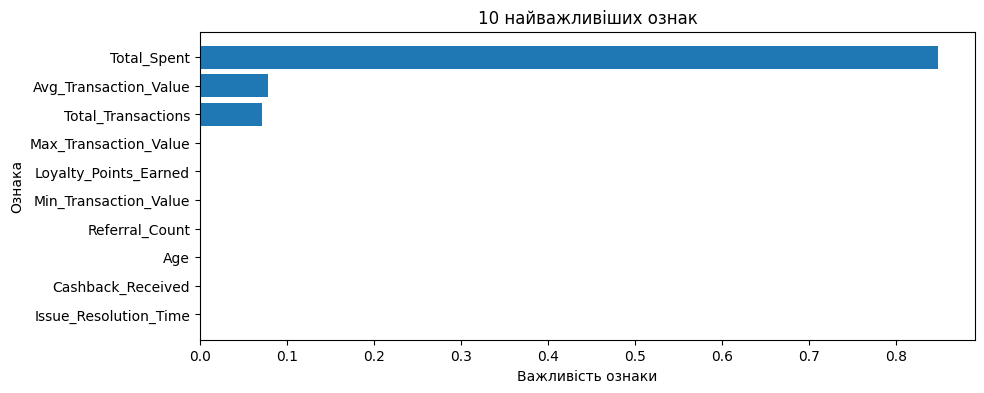

In [895]:
best_model = RandomForestRegressor(n_estimators=100).fit(X_train, y_train.reshape(-1))

importance = best_model.feature_importances_

top_10_indices = np.argsort(importance)[-10:]
top_features = X.columns[top_10_indices]

plt.figure(figsize=(10, 4))
plt.barh(range(len(top_10_indices)), importance[top_10_indices], align='center')
plt.yticks(range(len(top_10_indices)), top_features)
plt.xlabel('Важливість ознаки')
plt.ylabel('Ознака')
plt.title('10 найважливіших ознак')
plt.show()

In [896]:
X.head()

,Age,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score,Income_Level_Low,Income_Level_Middle,App_Usage_Frequency_Monthly,App_Usage_Frequency_Weekly,Preferred_Payment_Method_Debit Card,Preferred_Payment_Method_UPI,Preferred_Payment_Method_Wallet Balance
0,0.729520,-1.128009,1.254409,1.433746,1.705491,-0.456551,-0.406211,0.236785,-0.294421,0.013842,-0.184449,-1.168429,1.229388,-1.571932,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.087130,-0.621682,-0.517719,0.120452,-0.099668,0.277617,-1.043523,-1.545908,0.474535,-1.700047,-0.726903,0.160590,0.431562,-0.525085,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.812215,-1.575204,1.197718,-0.576284,0.672228,0.027815,1.106215,0.957448,-0.059941,0.699397,1.299394,-0.670047,-0.710274,-1.571932,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.986476,1.407326,0.167086,-0.591944,0.754357,1.411989,0.506952,1.374674,-0.383258,-0.466047,1.157835,1.323481,-0.778733,-0.176136,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.261888,0.900998,-0.695061,-0.411126,-0.421223,-0.068587,0.116955,-0.863175,0.518954,-1.357269,0.074225,-0.670047,-0.945538,1.568608,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [907]:
url_to_estimate = 'https://raw.githubusercontent.com/OlhaOsypova/Machine-Learning-and-Data-Analytics/refs/heads/main/Topic_4_regression/Task/clients_to_estimate.csv'

df_to_estimate = pd.read_csv(url_to_estimate)

df_to_estimate.head()

,Customer_ID,Age,Location,Income_Level,Total_Transactions,Avg_Transaction_Value,Max_Transaction_Value,Min_Transaction_Value,Total_Spent,Active_Days,Last_Transaction_Days_Ago,Loyalty_Points_Earned,Referral_Count,Cashback_Received,App_Usage_Frequency,Preferred_Payment_Method,Support_Tickets_Raised,Issue_Resolution_Time,Customer_Satisfaction_Score
0,cust_0860,50,Suburban,High,543,596.0589994879316$,1714.784777545023$,268.7142321224972$,3.236600e+05,250,361,2635,41,2019.948149,Daily,Debit Card,18,61.008314,6
1,cust_1604,66,Rural,Low,456,8800.17546689406$,38807.641761083454$,3153.691081237037$,4.012880e+06,349,211,1873,0,3163.905402,Daily,Debit Card,15,32.988608,8
2,cust_2245,46,Rural,Middle,754,1121.5742185939405$,3098.426240656642$,471.99152959088167$,8.456670e+05,43,274,4109,22,1515.538464,Weekly,Wallet Balance,4,16.183854,7
3,cust_6912,19,Urban,Middle,5,808.7034199851265$,3662.9134062873377$,204.50832004409645$,4.043517e+03,338,154,2939,25,3082.997460,Daily,UPI,20,51.023975,9
4,cust_0413,57,Rural,Middle,689,8577.766769212436$,31928.151472187823$,1996.522068052728$,5.910081e+06,330,15,557,21,189.162256,Daily,Wallet Balance,13,41.551875,9


In [908]:
columns_to_change = ['Avg_Transaction_Value', 'Max_Transaction_Value', 'Min_Transaction_Value']
df_to_estimate = convertCatToNum(df_to_estimate, columns_to_change, '$', '')

df_to_estimate = fillNaNNumerical(df_to_estimate, 'Age', 'mean')

columns_to_fill = ['Income_Level', 'App_Usage_Frequency']
df_to_estimate = fillNaNCategorical(df_to_estimate, columns_to_fill)

columns_to_delete = ['Customer_ID', 'Customer_ID', 'Location']

df_to_estimate = clean_dataframe(df_to_estimate, columns_to_delete)

In [909]:
df_to_estimate.index = range(df_to_estimate.shape[0])

In [910]:
categorical_columns = df_to_estimate.select_dtypes(include=['object']).columns
numerical_columns = df_to_estimate.select_dtypes(include=[float, int]).columns

df_to_estimate = standardizeDF(df_to_estimate, numerical_columns, categorical_columns)

In [911]:
pred_scaled = best_model.predict(df_to_estimate)
pred_scaled

array([-0.87215906, -0.02148145, -0.76138671, -0.94865772,  0.41304298,
        0.65955733,  1.75424563, -0.91267248,  2.56620609, -0.01283705,
       -0.90444718, -0.9241962 ,  0.1398756 , -0.8332751 , -0.64948926,
        1.32770386,  1.06979048, -0.04362611, -0.08222367, -0.86010821,
        0.52016224, -0.4750054 ,  0.03343923,  1.20459469,  1.39385435,
       -0.36081081, -0.83259768,  1.01105473, -0.1203706 , -0.57438127,
        0.49681022, -0.14301156, -0.94946629, -0.86069911, -0.28939669,
       -0.84435213, -0.41741365,  0.14291862, -0.89592267, -0.43818038,
       -0.66706924,  1.62189297,  0.9939712 ,  1.30951487])

In [912]:
pred_real_units = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1))

print('Спрогнозовано, що LTV нових клієнтів буде: ')
for i in range(len(pred_real_units)):
  print(f'Клієнт {i+1}: {pred_real_units[i][0]:.2f}')

Спрогнозовано, що LTV нових клієнтів буде: 
Клієнт 1: 161996.63
Клієнт 2: 470537.33
Клієнт 3: 202173.75
Клієнт 4: 134250.57
Клієнт 5: 628139.30
Клієнт 6: 717550.04
Клієнт 7: 1114593.39
Клієнт 8: 147302.42
Клієнт 9: 1409091.38
Клієнт 10: 473672.65
Клієнт 11: 150285.73
Клієнт 12: 143122.76
Клієнт 13: 529061.52
Клієнт 14: 176099.84
Клієнт 15: 242758.95
Клієнт 16: 959886.73
Клієнт 17: 866341.57
Клієнт 18: 462505.46
Клієнт 19: 448506.13
Клієнт 20: 166367.47
Клієнт 21: 666991.45
Клієнт 22: 306044.23
Клієнт 23: 490457.05
Клієнт 24: 915235.04
Клієнт 25: 983879.50
Клієнт 26: 347462.60
Клієнт 27: 176345.54
Клієнт 28: 845038.12
Клієнт 29: 434670.24
Клієнт 30: 270000.61
Клієнт 31: 658521.67
Клієнт 32: 426458.37
Клієнт 33: 133957.30
Клієнт 34: 166153.16
Клієнт 35: 373364.49
Клієнт 36: 172082.20
Клієнт 37: 326932.75
Клієнт 38: 530165.22
Клієнт 39: 153377.57
Клієнт 40: 319400.66
Клієнт 41: 236382.69
Клієнт 42: 1066589.09
Клієнт 43: 838841.92
Клієнт 44: 953289.58


In [906]:
df_to_estimate.to_excel('df.xlsx')